### Step 1:导入函数工具箱

In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Step 2:数据读取

In [2]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
Train_data = pd.read_csv('A:/kaggle/二手车预测/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('A:/kaggle/二手车预测/used_car_testA_20200313.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [3]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


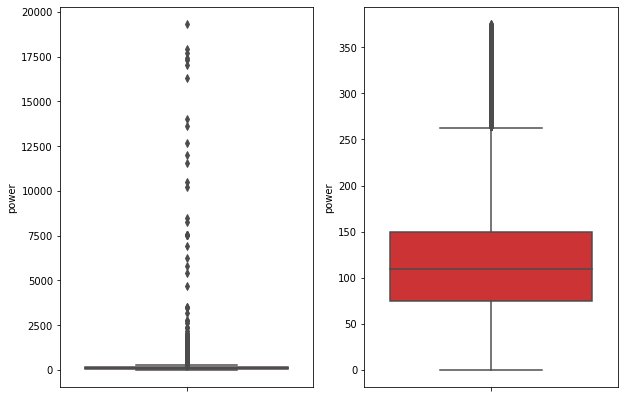

In [4]:
# 我们可以删掉一些异常数据，以 power 为例。  
# 这里删不删同学可以自行判断
# 但是要注意 test 的数据不能删 = = 不能掩耳盗铃是不是

Train_data = outliers_proc(Train_data, 'power', scale=3)

In [5]:
# 训练集和测试集放在一起，方便构造特征
Train_data['train']=1
TestA_data['train']=0
data = pd.concat([Train_data, TestA_data], ignore_index=True)
data

,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,...,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,...,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,...,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,...,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,...,-2.438353,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,...,2.834518,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199032,199995,4.0,4,20160320,0.0,0.0,15.0,4.0,20903,0.0,...,-1.981240,-0.357695,-0.918571,0.774826,-2.021739,0.284664,0.130044,0.049833,0.028807,0.004616
199033,199996,0.0,0,20160329,0.0,0.0,15.0,0.0,708,0.0,...,-1.154847,0.169073,-0.841710,1.328253,-1.292675,0.268101,0.108095,0.066039,0.025468,0.025971
199034,199997,0.0,1,20160305,1.0,1.0,15.0,49.0,6693,0.0,...,-1.390531,0.254420,0.388595,-0.704689,-1.480710,0.269432,0.105724,0.117652,0.057479,0.015669
199035,199998,0.0,1,20160404,0.0,1.0,15.0,27.0,96900,0.0,...,-0.911682,-2.057353,0.243566,-1.277411,-0.404881,0.261152,0.000490,0.137366,0.086216,0.051383


In [6]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [7]:
# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 但是这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
data['used_time'].isnull().sum()

15072

In [8]:
# 从邮编中提取城市信息，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data

In [9]:
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')
data

,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,...,v_9,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,...,0.097462,4385.0,1,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,...,0.020582,4757.0,4,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,...,0.027075,4382.0,2,1458.0,45000.0,8500.0,100.0,14373814.0,5425.058140,9851.83
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,...,0.000000,7125.0,,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,...,0.121534,1531.0,6,4662.0,31500.0,2300.0,20.0,15414322.0,3344.689763,3305.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199032,199995,4.0,4,20160320,0.0,0.0,15.0,4.0,20903,0.0,...,0.004616,7261.0,3,16575.0,99999.0,5999.0,12.0,138279069.0,8089.863295,8342.13
199033,199996,0.0,0,20160329,0.0,0.0,15.0,0.0,708,0.0,...,0.025971,6014.0,1,31429.0,68500.0,3199.0,13.0,173719698.0,6261.371627,5527.19
199034,199997,0.0,1,20160305,1.0,1.0,15.0,49.0,6693,0.0,...,0.015669,4345.0,3,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86
199035,199998,0.0,1,20160404,0.0,1.0,15.0,27.0,96900,0.0,...,0.051383,NaN,1,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86


In [10]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多，= =
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


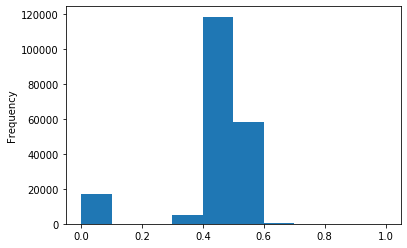

In [11]:
# 我们对其取 log，在做归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

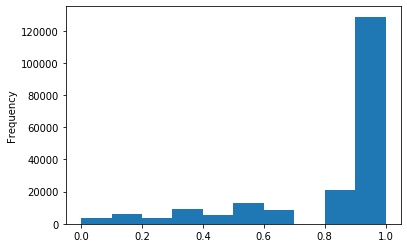

In [12]:
# 所以我们可以直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [13]:
# 除此之外 还有我们刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 这里不再一一举例分析了，直接做变换，
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

In [14]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'city','power_bin'])

In [15]:
print(data.shape)
data.columns

(199037, 381)


Index(['SaleID', 'creatDate', 'kilometer', 'name', 'offerType', 'power',
       'price', 'regDate', 'regionCode', 'seller',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=381)

In [16]:
# 提取年份
data['regYear'] = data['regDate'].map(lambda x:int(str(x)[:4]))
data['createYear'] = data['creatDate'].map(lambda x:int(str(x)[:4]))

In [17]:
# 提取月份
data['regMonth'] = data['regDate'].map(lambda x:int(str(x)[4:6]))
data['createMonth'] = data['creatDate'].map(lambda x:int(str(x)[4:6]))

In [18]:
# # 计算上线日期与注册日期想差月份数
# data['months'] = (data['createYear']-data['regYear'])*12+(data['createMonth']-data['regMonth'])
# data['years'] = all_features['months'] / 12

In [19]:
# # 查看月份数统计值
# data['months'].describe()

In [20]:
# # 月份数分布
# all_features['months'].hist()

In [21]:
# 先删除掉一些不要的特征
data = data.drop(['SaleID', 'name', 'regDate', 'seller',
                                  'offerType', 'creatDate', 'regYear', 'regionCode',
                                  'createYear', 'regMonth', 'createMonth'], axis=1)

In [22]:
data.dtypes

kilometer         float64
power             float64
price             float64
train               int64
v_0               float64
                   ...   
power_bin_25.0      uint8
power_bin_26.0      uint8
power_bin_27.0      uint8
power_bin_28.0      uint8
power_bin_29.0      uint8
Length: 374, dtype: object

In [23]:
corr = data.corr()

In [24]:
import itertools
feature_group = list(itertools.combinations(corr.columns, 2))

In [25]:
# 删除相关性高的变量
def filter_corr(corr, cutoff=0.7):
    cols = []
    for i,j in feature_group:
        if corr.loc[i, j] > cutoff:
            i_avg = corr[i][corr[i] != 1].mean()
            j_avg = corr[j][corr[j] != 1].mean()
            if i_avg >= j_avg:
                cols.append(i)
            else:
                cols.append(j)
    return set(cols)

In [26]:
# 相关系数高的组合去掉平均相关系数高的那个
drop_cols = filter_corr(corr, cutoff=0.9)
drop_cols

{'brand_16',
 'brand_price_average',
 'brand_price_median',
 'brand_price_sum',
 'v_2',
 'v_4',
 'v_6'}

In [27]:
data = data.drop(['v_6', 'v_4', 'brand_16','brand_price_average', 'brand_price_median','brand_price_sum','v_2'], axis=1)